In [1]:
#!/usr/bin/python
# updated DBR 8/2021 #

%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import os

sns.set_style("ticks")

import warnings
warnings.filterwarnings(action='once')


In [2]:
#first do the experiment on those without TN

#not using PWH122 and MACS14218
PWH_ppts = ['PWH22','PWH548','PWH746','PWH583',]
ctl_ppts = ['MACS10136','MACS13042','MACS14173','WIHS']

PWH_cz=['salmon','peru','tab:red','maroon',]#,'firebrick']
ctl_cz=['lightblue','teal','tab:blue','navy']#,'turquoise']

cz=PWH_cz+ctl_cz
pp=PWH_ppts+ctl_ppts
hs=[1,1,1,1,0,0,0,0] #HIV status


In [3]:
## collect expansion and contraction data will use for fitting ##

#big lists of changes
bigl=[]

for ip,pid in enumerate(pp):
    
    df0 = pd.read_csv('cleanTCRdata/restricted/'+pid+'_t0.csv') #note this hasn't been downsampled yet
    df1 = pd.read_csv('cleanTCRdata/restricted/'+pid+'_t1.csv') 
    df2 = pd.read_csv('cleanTCRdata/restricted/'+pid+'_t2.csv') 

    #the df holding all rearrangements that are present at any time (merge and reformat a little)
    all_df = pd.merge(df0, df1, how='outer', on=['extended_rearrangement'])
    all_df = pd.merge(all_df, df2, how='outer', on=['extended_rearrangement'])
    all_df = all_df.fillna(0) #fill all zeros

    all_df = all_df.rename(columns={'templates_x': 'counts_t0', 'templates_y': 'counts_t1', 'templates': 'counts_t2'})
    
    #now make resampled dataframes
    #rs_df=pd.DataFrame()
    pa_df=pd.DataFrame()
    #if I drop zeros here is it faster?
    #pa_df=pa_df.replace(0,np.nan).dropna() #just get nonzeros for visualization on log scale
    for tp in range(3):
        N=np.sum(all_df['counts_t'+str(tp)])
        pa_df['pa'+str(tp)] = all_df['counts_t'+str(tp)]/N
    #    rs_df['rs'+str(tp)]= np.random.multinomial(n=sample_size,pvals=pa_df['pa'+str(tp)])
        
    #loop over 0-1 and 1-2 time points
    for i in range(2):
        pa_f=pa_df['pa'+str(i+1)]
        pa_i=pa_df['pa'+str(i)]

        fold_changes = pa_f[(pa_i>0) & (pa_f>0)]/pa_i[(pa_i>0) & (pa_f>0)] #restrict to nonzeros (to avoid nan)
        init_sizes = pa_i[(pa_i>0) & (pa_f>0)]
        
        bigl.append([pid,i+1,cz[ip],np.array(fold_changes),np.array(init_sizes),N])


In [5]:
#make an average and fit it with polynomial

binz=np.arange(0,30,1)+1
avgl=[0,0,0,0]
last_x = 10 #how far to go out for fits

for ipt,pt in enumerate(bigl):
    fcs=np.array(pt[3])
    expands = fcs[fcs>1]
    contracts = 1/fcs[fcs<1]
    ce,xe = np.histogram(expands,bins=binz,density=True)
    cc,xc = np.histogram(contracts,bins=binz,density=True)
    
    if ipt<8:
        avgl[0]+=ce
        avgl[1]+=cc
    
    if ipt>8:
        avgl[2]+=ce
        avgl[3]+=cc
        

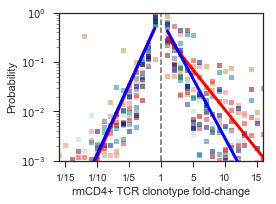

In [20]:
#now do histograms of all data with mean line
binz=np.arange(0,30,1)+1
mz='s'
plt.figure(figsize=(4,3))
laml=[]
for ipt,pt in enumerate(bigl):
    fcs=np.array(pt[3])
    expands = fcs[fcs>1]
    contracts = 1/fcs[fcs<1]
    
    ce,xe = np.histogram(expands,bins=binz,density=True)
    cc,xc = np.histogram(contracts,bins=binz,density=True)

    plt.plot(xe[:-1],ce,color=pt[2],marker=mz,ls='',alpha=0.5,markersize=5)
    plt.plot(-xc[:-1],cc,color=pt[2],marker=mz,ls='',alpha=0.5,markersize=5)

    #deal with nan
    ce[ce==0]=np.min(ce[ce>0])
    cc[cc==0]=np.min(cc[cc>0])
    
    fit_lame, fit_y0 = np.polyfit(xe[:last_x],np.log(ce[:last_x]),1)
    fit_lamc, fit_y0 = np.polyfit(xe[:last_x],np.log(cc[:last_x]),1)
    
    laml.append([pt[0],fit_lame,fit_lamc]) #list for lambdas

xx=xe[:-1]
for ai in range(4):
    c=avgl[ai]/8
    fit_lam, fit_y0 = np.polyfit(xe[:last_x],np.log(c[:last_x]),1)

    fex=np.exp(fit_y0)*np.exp(fit_lam*xx)
    fex=fex/np.sum(fex)
    
    if ai<2:
        cz='red'
    else:
        cz='blue'
    
    if ai in [0,2]:
        plt.plot(xx,fex/np.sum(fex),ls='-',color=cz,lw=3)
    else:
        plt.plot(-xx,fex/np.sum(fex),ls='-',color=cz,lw=3)

plt.semilogy()
plt.ylim([1e-3,1])
plt.ylabel('Probability')
plt.xlabel('rmCD4+ TCR clonotype fold-change')
plt.xticks(np.linspace(-20,20,9),['1/20','1/15','1/10','1/5','1','5','10','15','20'])
plt.xlim([-16,16])
plt.axvline(0,ls='--',color='gray')

plt.tight_layout()
plt.savefig('figures/allfoldchanges.pdf',dpi=600)    


In [30]:
lamdf=pd.DataFrame(laml,columns=['pid','lam_expand','lam_contract'])

#do tests

#PWH vs HIVneg expand
print(st.mannwhitneyu(lamdf.iloc[:8]['lam_expand'],lamdf.iloc[8:]['lam_expand']))

#PWH expand vs contract
print(st.mannwhitneyu(lamdf.iloc[:8]['lam_expand'],lamdf.iloc[:8]['lam_contract']))
print(st.mannwhitneyu(lamdf.iloc[8:]['lam_expand'],lamdf.iloc[8:]['lam_contract']))

#PWH vs HIVneg contract
print(st.mannwhitneyu(lamdf.iloc[:8]['lam_contract'],lamdf.iloc[8:]['lam_contract']))


MannwhitneyuResult(statistic=10.0, pvalue=0.011974337439879718)
MannwhitneyuResult(statistic=18.0, pvalue=0.07812697901368165)
MannwhitneyuResult(statistic=16.0, pvalue=0.05178093558826699)
MannwhitneyuResult(statistic=17.0, pvalue=0.06390380047377232)


/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:4975: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  "`alternative` is deprecated.", DeprecationWarning)


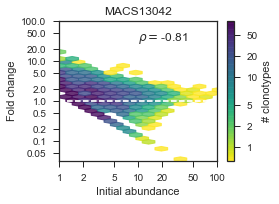

In [12]:
#hexbin 1 time point example!

ii=10
foldchg = bigl[ii][3]
initsize = bigl[ii][4]

plt.figure(figsize=(4,3))
xi=np.log10(np.array(initsize)/np.sum(init_sizes)*bigl[ii][5]) #renormalize x axis to observed abundance 
plt.hexbin(xi,np.log10(foldchg),gridsize=(20,20),cmap='viridis_r',mincnt=1,bins='log',vmin=0.5,vmax=2.5,alpha=0.8)

#get the slope and plot?
#m,y0 = np.polyfit(xi,np.log10(foldchg),1)
#xs=np.linspace(-5,-1,100)
#plt.plot(xs,xs*m+y0,color='k')

plt.axhline(0,ls='--',color='white')
plt.title(bigl[ii][0])
plt.annotate(r'$\rho=$'+str(np.round(st.spearmanr(foldchg,initsize)[0],2)),[1,1.5])

plt.xlabel('Initial abundance')
plt.ylabel('Fold change')
plt.yticks(np.log10(np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000])),np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000]))
plt.ylim([-1.5,2])
plt.xticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])),np.array([1,2,5,10,20,50,100,200,500,1000]))
plt.xlim([0,2])

cbar=plt.colorbar()
cbar.set_label(r'# clonotypes')
cbar.set_ticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])))
cbar.set_ticklabels(np.array([1,2,5,10,20,50,100,200,500,1000]))

plt.tight_layout()
plt.savefig('figures/hexbin_example.pdf',dpi=600)


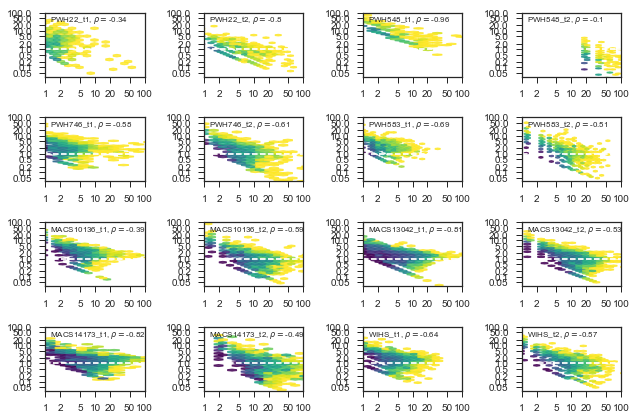

In [38]:
#all examples

plt.figure(figsize=(9,6))
for ii in range(len(bigl)):
    foldchg = bigl[ii][3]
    initsize = bigl[ii][4]

    xi=np.log10(np.array(initsize)/np.sum(init_sizes)*bigl[ii][5]) #renormalize x axis to observed abundance 

    plt.subplot(4,4,ii+1)
    plt.hexbin(xi,np.log10(foldchg),gridsize=(20,20),cmap='viridis_r',mincnt=1,bins='log',vmin=0.5,vmax=2.5,alpha=0.8)
    plt.axhline(0,ls='--',color='white')
    plt.annotate(bigl[ii][0]+'_t'+str(bigl[ii][1])+r', $\rho=$'+str(np.round(st.spearmanr(foldchg,initsize)[0],2)),[0.1,1.5], fontsize=8)

    plt.yticks(np.log10(np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000])),np.array([1/100,1/50,1/20,1/10,1/5,1/2,1,2,5,10,20,50,100,200,500,1000]))
    plt.ylim([-1.5,2])
    plt.xticks(np.log10(np.array([1,2,5,10,20,50,100,200,500,1000])),np.array([1,2,5,10,20,50,100,200,500,1000]))
    plt.xlim([0,2])

plt.tight_layout()
plt.savefig('figures/hexbin_all.pdf',dpi=600)


MannwhitneyuResult(statistic=31.0, pvalue=0.4790609632888714)


/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:4975: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  "`alternative` is deprecated.", DeprecationWarning)


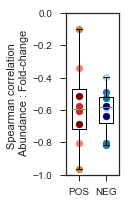

In [32]:
#tabulate correlation coefficients
rl=[]
plt.figure(figsize=(2,3))
for ii in range(len(bigl)):
    foldchg = bigl[ii][3]
    initsize = bigl[ii][4]
    rho=st.spearmanr(foldchg,initsize)[0]
    rl.append(rho)
    if ii<8:
        plt.scatter(1,rho,c=bigl[ii][2])
    else:
        plt.scatter(2,rho,c=bigl[ii][2])
    
plt.boxplot([rl[:8],rl[8:]],widths=0.5)
plt.ylim([-1,0])
plt.xlim([0.5,2.5])
#plt.xlabel('HIV status')
plt.xticks([1,2],['POS','NEG'])
plt.ylabel('Spearman correlation \n Abundance : Fold-change')
print(st.mannwhitneyu(rl[:8],rl[8:]))
plt.tight_layout()
plt.savefig('figures/corrs_box2.pdf',dpi=600)


[]

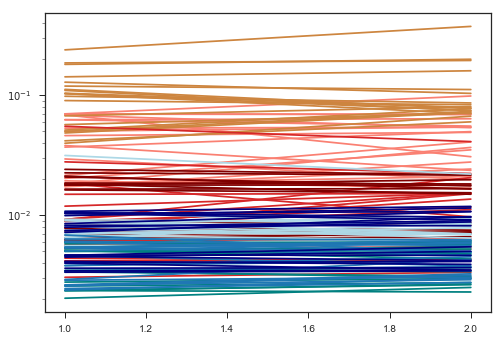

In [33]:
#another way to do the clone sim, a lot easier huh...

for ii in range(len(bigl)):
    foldchg = bigl[ii][3]
    initsize = bigl[ii][4]

    for rr in range(10):
        indz=np.random.randint(0,len(initsize),100)

        a1=np.sum(initsize[indz])/np.sum(initsize)
        a2=np.sum(initsize[indz]*foldchg[indz])/np.sum(initsize*foldchg)

        plt.plot([1,2],[a1,a2],color=bigl[ii][2])
        
plt.semilogy()